In [1]:
import warnings
warnings.filterwarnings('ignore') 

# from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

### Setup
Let's begin by examining the COMPAS data set.  This data set consists of defendent information from 
Broward Couty, Florida. Let's suppose that some adversary wants to _mask_ baised or racist behavior on this data set.

In [2]:
# Get the data set and do some preprocessing
params = Params("model_configurations/experiment_params.json")
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_compas_data(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

print(features)

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race', 'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index('race')
unrelated_indcs = features.index('unrelated_column')
X = X.values
X

['age', 'two_year_recid', 'priors_count', 'length_of_stay', 'c_charge_degree_F', 'c_charge_degree_M', 'sex_Female', 'sex_Male', 'race', 'unrelated_column']


array([[69,  0,  0, ...,  1,  0,  0],
       [34,  1,  0, ...,  1,  1,  1],
       [24,  1,  4, ...,  1,  1,  0],
       ...,
       [57,  0,  0, ...,  1,  0,  1],
       [33,  0,  3, ...,  0,  1,  1],
       [23,  1,  2, ...,  0,  0,  0]])

Next, let's set up our model f and psi.  f is the what we _actually_ want to classify the data by and psi
is what we want LIME/SHAP to explain.

In [3]:
class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [4]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, categorical_features=categorical_feature_indcs)

NameError: name 'Adversarial_Lime_Model' is not defined

Great, that's it! Now let's look at LIME explanations.

We'll go through SHAP after.

In [5]:
# Let's just look at a the first example in the test set
ex_indc = np.random.choice(xtest.shape[0])

# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs)

normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba).as_list()

print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs)

adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba).as_list()

print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

Explanation on biased f:
 [('race=0', -0.9986343456272181), ('sex_Female=0', 2.002798122844831e-05), ('unrelated_column=0', -1.7913202734359346e-05)] 


Explanation on adversarial model:
 [('unrelated_column=0', -0.9981443627774021), ('sex_Male=0', 0.0012015987966745123), ('two_year_recid=1', -0.0005130675716728551)] 

Prediction fidelity: 1.0


### LIME Results
What we have is the top three features of the explanation on the biased model followed by the explanation on that same instance using the adversarial model. We see that the top feature is now the randomly drawn column, indicating that the attack was able to fool LIME. We also see that the adversarial model predicts this instance _the same_ as the biased model (fidelity=1)—although the model predicts the same results, its reasoning has changed.

Next, let's look at the SHAP adversarial model.  We'll go through a similar process as above except using SHAP.

In [25]:
# import numpy as np
# import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# from sklearn.model_selection import train_test_split

from copy import deepcopy

import shap

class Adversarial_Model(object):
	"""	A scikit-learn style adversarial explainer base class for adversarial models.  This accetps 
	a scikit learn style function f_obscure that serves as the _true classification rule_ for in distribution
	data.  Also, it accepts, psi_display: the classification rule you wish to display by explainers (e.g. LIME/SHAP).
	Ideally, f_obscure will classify individual instances but psi_display will be shown by the explainer.

	Parameters
	----------
	f_obscure : function
	psi_display : function
	"""
	def __init__(self, f_obscure, psi_display):
		self.f_obscure = f_obscure
		self.psi_display = psi_display

		self.cols = None
		self.scaler = None
		self.numerical_cols = None

	def predict_proba(self, X, threshold=0.5):
		""" Scikit-learn style probability prediction for the adversarial model.  

		Parameters
		----------
		X : np.ndarray

		Returns
		----------
		A numpy array of the class probability predictions of the advesarial model.
		"""
		if self.perturbation_identifier is None:
			raise NameError("Model is not trained yet, can't perform predictions.")

		# generate the "true" predictions on the data using the "bad" model -- this is f in the paper
		predictions_to_obscure = self.f_obscure.predict_proba(X)

		# generate the "explain" predictions -- this is psi in the paper

		predictions_to_explain_by = self.psi_display.predict_proba(X)

		# in the case that we're only considering numerical columns
		if self.numerical_cols:
			X = X[:,self.numerical_cols]

		# allow thresholding for finetuned control over psi_display and f_obscure
		pred_probs = self.perturbation_identifier.predict_proba(X)
		perturbation_preds = (pred_probs[:,1] >= threshold)

		sol = np.where(np.array([perturbation_preds == 1,perturbation_preds==1]).transpose(), predictions_to_obscure, predictions_to_explain_by)

		return sol

	def predict(self, X):
		"""	Scikit-learn style prediction. Follows from predict_proba.

		Parameters
		----------
		X : np.ndarray
		
		Returns
		----------
		A numpy array containing the binary class predictions.
		"""
		pred_probs = self.predict_proba(X)
		return np.argmax(pred_probs,axis=1)

	def score(self, X_test, y_test):	
		""" Scikit-learn style accuracy scoring.

		Parameters:
		----------
		X_test : X_test
		y_test : y_test

		Returns:
		----------
		A scalar value of the accuracy score on the task.
		"""

		return np.sum(self.predict(X_test)==y_test) / y_test.size

	def get_column_names(self):
		""" Access column names."""

		if self.cols is None:
			raise NameError("Train model with pandas data frame to get column names.")

		return self.cols

	def fidelity(self, X):
		""" Get the fidelity of the adversarial model to the original predictions.  High fidelity means that
		we're predicting f along the in distribution data.
		
		Parameters:
		----------
		X : np.ndarray	

		Returns:
		----------
		The fidelity score of the adversarial model's predictions to the model you're trying to obscure's predictions.
		"""

		return (np.sum(self.predict(X) == self.f_obscure.predict(X)) / X.shape[0])

class Adversarial_Lime_Model(Adversarial_Model):
	""" Lime adversarial model.  Generates an adversarial model for LIME style explainers using the Adversarial Model
	base class.

	Parameters:
	----------
	f_obscure : function
	psi_display : function
	perturbation_std : float
	"""
	def __init__(self, f_obscure, psi_display, perturbation_std=0.3):
		super(Adversarial_Lime_Model, self).__init__(f_obscure, psi_display)
		self.perturbation_std = perturbation_std

	def train(self, X, y, feature_names, perturbation_multiplier=30, categorical_features=[], rf_estimators=100, estimator=None):
		""" Trains the adversarial LIME model.  This method trains the perturbation detection classifier to detect instances
		that are either in the manifold or not if no estimator is provided.
		
		Parameters:
		----------
		X : np.ndarray of pd.DataFrame
		y : np.ndarray
		perturbation_multiplier : int
		cols : list
		categorical_columns : list
		rf_estimators : integer
		estimaor : func
		"""
		if isinstance(X, pd.DataFrame):
			cols = [c for c in X]
			X = X.values
		elif not isinstance(X, np.ndarray):
			raise NameError("X of type {} is not accepted. Only pandas dataframes or numpy arrays allowed".format(type(X)))

		self.cols = feature_names
		all_x, all_y = [], []

		# loop over perturbation data to create larger data set
		for _ in range(perturbation_multiplier):
			perturbed_xtrain = np.random.normal(0,self.perturbation_std,size=X.shape)
			p_train_x = np.vstack((X, X + perturbed_xtrain))
			p_train_y = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

			all_x.append(p_train_x)
			all_y.append(p_train_y)

		all_x = np.vstack(all_x)
		all_y = np.concatenate(all_y)

		# it's easier to just work with numerical columns, so focus on them for exploiting LIME
		self.numerical_cols = [feature_names.index(c) for c in feature_names if feature_names.index(c) not in categorical_features]

		if self.numerical_cols == []:
			raise NotImplementedError("We currently only support numerical column data. If your data set is all categorical, consider using SHAP adversarial model.")

		# generate perturbation detection model as RF
		xtrain = all_x[:,self.numerical_cols]
		xtrain, xtest, ytrain, ytest = train_test_split(xtrain, all_y, test_size=0.2)

		if estimator is not None:
			self.perturbation_identifier = estimator.fit(xtrain, ytrain)
		else:
			self.perturbation_identifier = RandomForestClassifier(n_estimators=rf_estimators).fit(xtrain, ytrain)

		ypred = self.perturbation_identifier.predict(xtest)
		self.ood_training_task_ability = (ytest, ypred)

		return self

class Adversarial_Kernel_SHAP_Model(Adversarial_Model):
	""" SHAP adversarial model.  Generates an adversarial model for SHAP style perturbations.

	Parameters:
	----------
	f_obscure : function
	psi_display : function
	"""
	def __init__(self, f_obscure, psi_display):
		super(Adversarial_Kernel_SHAP_Model, self).__init__(f_obscure, psi_display)

	def train(self, X, y, feature_names, background_distribution=None, perturbation_multiplier=10, n_samples=2e4, rf_estimators=100, n_kmeans=10, estimator=None):
		""" Trains the adversarial SHAP model. This method perturbs the shap training distribution by sampling from 
		its kmeans and randomly adding features.  These points get substituted into a test set.  We also check to make 
		sure that the instance isn't in the test set before adding it to the out of distribution set. If an estimator is 
		provided this is used.

		Parameters:
		----------
		X : np.ndarray
		y : np.ndarray
		features_names : list
		perturbation_multiplier : int
		n_samples : int or float
		rf_estimators : int
		n_kmeans : int
		estimator : func

		Returns:
		----------
		The model itself.
		"""
		if isinstance(X, pd.DataFrame):
			X = X.values
		elif not isinstance(X, np.ndarray):
			raise NameError("X of type {} is not accepted. Only pandas dataframes or numpy arrays allowed".format(type(X)))

		self.cols = feature_names

		# This is the mock background distribution we'll pull from to create substitutions
		if background_distribution is None:
			background_distribution = shap.kmeans(X,n_kmeans).data
		repeated_X = np.repeat(X, perturbation_multiplier, axis=0)

		new_instances = []
		equal = []

		# We generate n_samples number of substutions
		# MP - this just seems to be selecting a random instance
		for _ in range(int(n_samples)):
			i = np.random.choice(X.shape[0])
			point = deepcopy(X[i, :])
			print(background_distribution.shape)

			# iterate over points, sampling and updating
			# MP - seems here we are using data for random features in order to generate points off the manifold
			for _ in range(X.shape[1]):
				j = np.random.choice(X.shape[1])
				point[j] = deepcopy(background_distribution[np.random.choice(background_distribution.shape[0]),j])
	
			new_instances.append(point)

		substituted_training_data = np.vstack(new_instances)
		all_instances_x = np.vstack((repeated_X, substituted_training_data))

		# make sure feature truly is out of distribution before labeling it
		xlist = X.tolist()
		ys = np.array([1 if substituted_training_data[val,:].tolist() in xlist else 0\
						 for val in range(substituted_training_data.shape[0])])

		all_instances_y = np.concatenate((np.ones(repeated_X.shape[0]),ys))

		xtrain,xtest,ytrain,ytest = train_test_split(all_instances_x, all_instances_y, test_size=0.2)

		if estimator is not None:
			self.perturbation_identifier = estimator.fit(xtrain,ytrain)
		else:
			self.perturbation_identifier = RandomForestClassifier(n_estimators=rf_estimators).fit(xtrain,ytrain)

		ypred = self.perturbation_identifier.predict(xtest)
		self.ood_training_task_ability = (ytest, ypred)

		return self


In [26]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features)

(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(

KeyboardInterrupt: 

In [7]:
adv_shap_values


NameError: name 'adv_shap_values' is not defined

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.37567509  0.        ]]


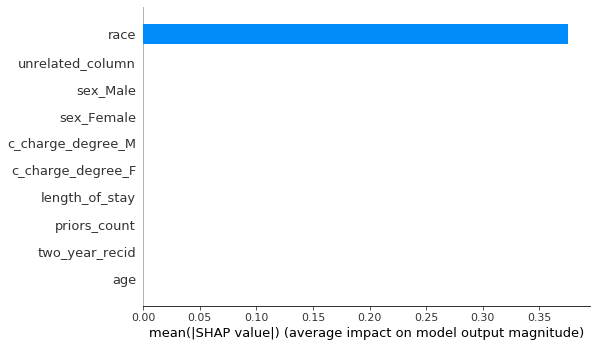

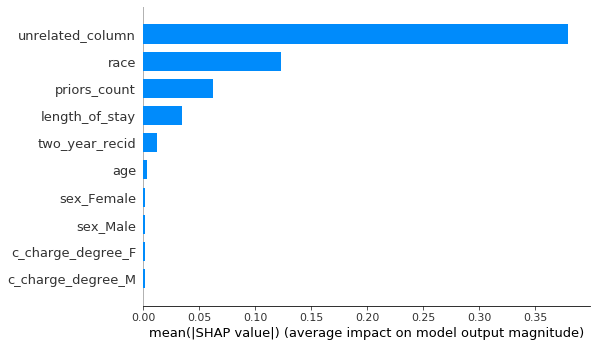

Fidelity: 1.0


In [8]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
print(np.array(biased_shap_values))
shap.summary_plot(np.array(biased_shap_values), feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")
print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

### SHAP Results
The first plot is SHAP applied to the biased model.  The second plot is SHAP applied to the adversarial model.  These plots give a summary of the SHAP values for each feature.  We see the randomly drawn column looks like it has
much more impact on the model than race does now, though race still looks important.  We also see that adversarial model predicts this instance the same as the biased model.

### Commentary
What do these results mean? It's _possible_ for an adversary to exploit perturabtion based post hoc explanation techniques like LIME and SHAP.  In safety concerned situations, it is prudent _not_ to trust post hoc explanations given by LIME and SHAP because adversaries can potentially exploit their explanations.